In [1]:
# !pip install matplotlib
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

Matplotlib is building the font cache; this may take a moment.


In [16]:
def changeAmplitude(filename):
    file_contents = tf.io.read_file(filename)
    wave, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wave = tf.squeeze(wave, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wave = tfio.audio.resample(wave, rate_in=sample_rate, rate_out=16000)
    return wave


In [17]:
CAPUCHIN = os.path.join('Dataset', 'Parsed_Capuchinbird_Clips')
NON_CAPUCHIN = os.path.join('Dataset', 'Parsed_Not_Capuchinbird_Clips')

In [18]:
yes = tf.data.Dataset.list_files(CAPUCHIN+'\*.wav')
no = tf.data.Dataset.list_files(NON_CAPUCHIN+'\*.wav')

In [19]:
positives = tf.data.Dataset.zip((yes, tf.data.Dataset.from_tensor_slices(tf.ones(len(yes)))))
negatives = tf.data.Dataset.zip((no, tf.data.Dataset.from_tensor_slices(tf.zeros(len(no)))))
data = positives.concatenate(negatives)

In [20]:
lengths = []
for file in os.listdir(os.path.join('Dataset', 'Parsed_Capuchinbird_Clips')):
    wave = changeAmplitude(os.path.join('Dataset', 'Parsed_Capuchinbird_Clips', file))
    lengths.append(len(wave))

In [21]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [22]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [16]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [23]:
def preprocess(file_path, label):
    wave = changeAmplitude(file_path)
    if wave is None:
        print(f"Skipping file {file_path} as it could not be loaded.")
        return None
    wave = wave[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wave), dtype=tf.float32)
    wave = tf.concat([wave, zero_padding], 0)
    spectrogram = tf.signal.stft(wave, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=-1)
    return spectrogram, label

In [24]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [25]:
spectrogram, label = preprocess(filepath, label)

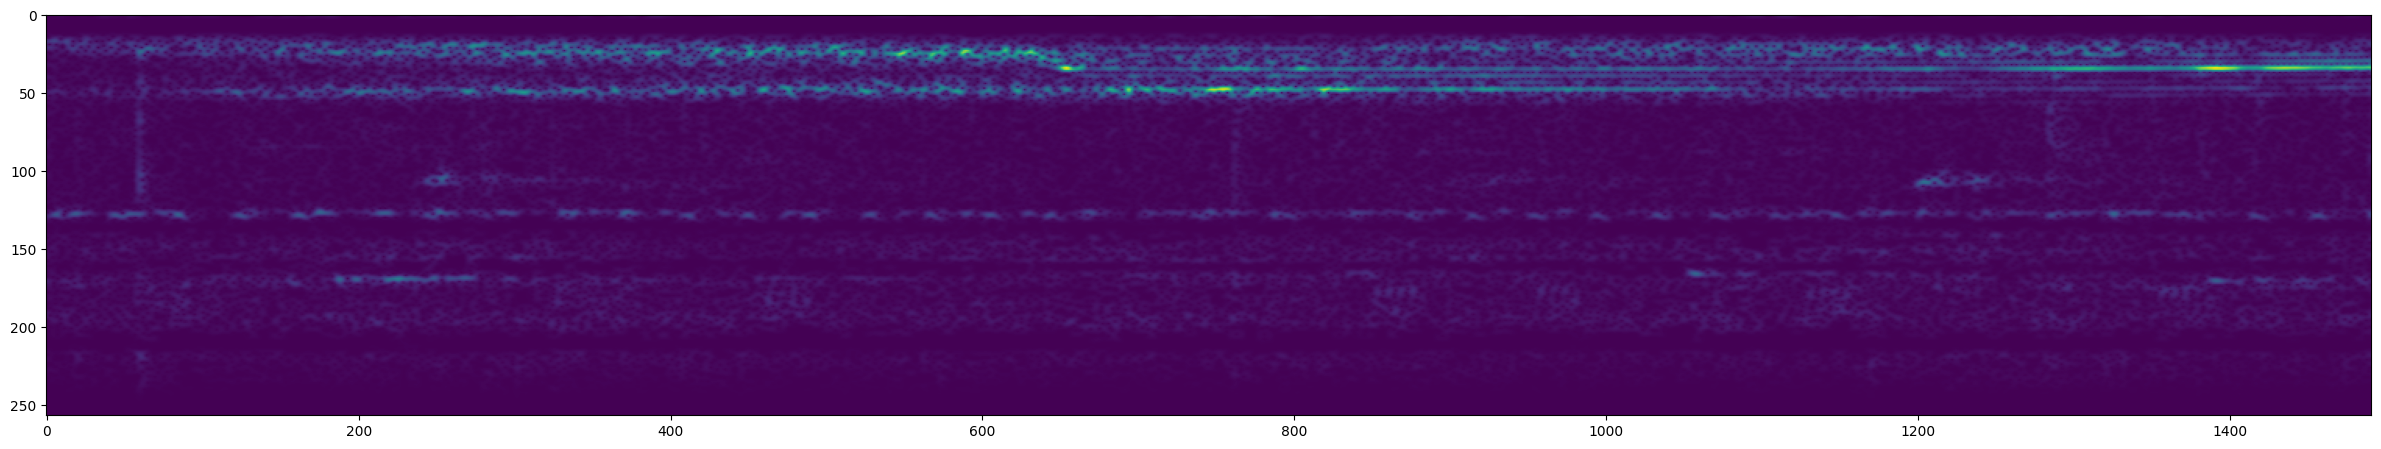

In [26]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [27]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [28]:
train = data.take(36)
test = data.skip(36).take(15)

In [29]:
samples, labels = train.as_numpy_iterator().next()

In [30]:
samples.shape

(16, 1491, 257, 1)

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [32]:
model = Sequential()
model.add(Conv2D(4, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(4, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [33]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1489, 255, 4)      40        
                                                                 
 conv2d_1 (Conv2D)           (None, 1487, 253, 4)      148       
                                                                 
 flatten (Flatten)           (None, 1504844)           0         
                                                                 
 dense (Dense)               (None, 16)                24077520  
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 24,077,725
Trainable params: 24,077,725
Non-trainable params: 0
_________________________________________________________________


In [29]:
hist = model.fit(train, epochs=4, validation_data=test, batch_size=16)

Epoch 1/4
36/36 [==============================] - 34s 931ms/step - loss: 2.2575 - recall: 0.9177 - precision: 0.7713 - val_loss: 2.2000 - val_recall: 1.0000 - val_precision: 0.9054
Epoch 2/4
36/36 [==============================] - 35s 970ms/step - loss: 0.3652 - recall: 0.9937 - precision: 0.9578 - val_loss: 0.1040 - val_recall: 1.0000 - val_precision: 0.9839
Epoch 3/4
36/36 [==============================] - 36s 996ms/step - loss: 0.1634 - recall: 0.9871 - precision: 0.9808 - val_loss: 0.0935 - val_recall: 1.0000 - val_precision: 0.9706
Epoch 4/4
36/36 [==============================] - 39s 1s/step - loss: 0.0618 - recall: 0.9872 - precision: 1.0000 - val_loss: 0.0590 - val_recall: 0.9848 - val_precision: 1.0000


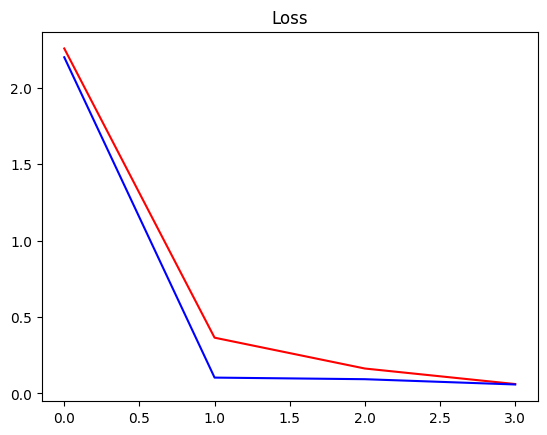

In [30]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

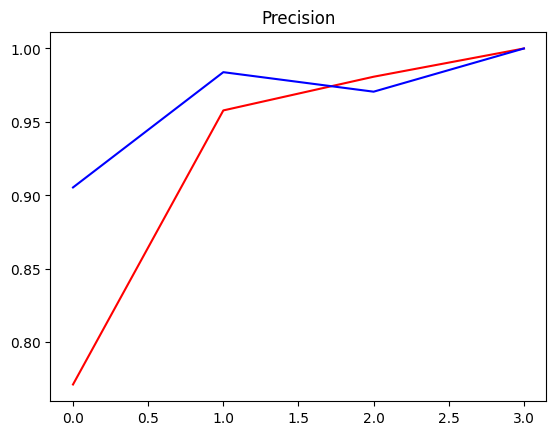

In [31]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

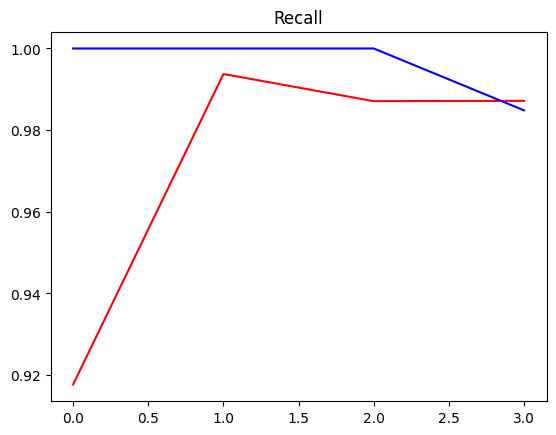

In [32]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

In [33]:
X_test, y_test = test.as_numpy_iterator().next()

In [34]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 460ms/step


In [35]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [36]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [39]:
mp3 = os.path.join('Dataset', 'Forest Recordings', 'recording_00.mp3')

In [40]:
wav = load_mp3_16k_mono(mp3)

In [41]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [42]:
samples, index = audio_slices.as_numpy_iterator().next()

In [43]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [44]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [45]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

3/3 [==============================] - 4s 931ms/step


In [46]:
from itertools import groupby

In [47]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [51]:
calls

13

In [55]:
results = {}
for file in os.listdir(os.path.join('Dataset', 'Forest Recordings')):
    FILEPATH = os.path.join('Dataset','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    results[file] = yhat

1/1 [==============================] - 1s 1s/step


In [56]:
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

{'recording_00.mp3': [0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_01.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_02.mp3': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'recording_03.mp3': [0,
  0,
  0,
  

In [57]:
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

{'recording_00.mp3': 5,
 'recording_01.mp3': 0,
 'recording_02.mp3': 0,
 'recording_03.mp3': 0,
 'recording_04.mp3': 4,
 'recording_05.mp3': 0,
 'recording_06.mp3': 5,
 'recording_07.mp3': 2,
 'recording_08.mp3': 25,
 'recording_09.mp3': 0,
 'recording_10.mp3': 5,
 'recording_11.mp3': 3,
 'recording_12.mp3': 1,
 'recording_13.mp3': 0,
 'recording_14.mp3': 0,
 'recording_15.mp3': 2,
 'recording_16.mp3': 3,
 'recording_17.mp3': 3,
 'recording_18.mp3': 1,
 'recording_19.mp3': 0,
 'recording_20.mp3': 0,
 'recording_21.mp3': 1,
 'recording_22.mp3': 2,
 'recording_23.mp3': 5,
 'recording_24.mp3': 0,
 'recording_25.mp3': 12,
 'recording_26.mp3': 2,
 'recording_27.mp3': 0,
 'recording_28.mp3': 12,
 'recording_29.mp3': 0,
 'recording_30.mp3': 3,
 'recording_31.mp3': 1,
 'recording_32.mp3': 2,
 'recording_33.mp3': 0,
 'recording_34.mp3': 4,
 'recording_35.mp3': 0,
 'recording_36.mp3': 0,
 'recording_37.mp3': 3,
 'recording_38.mp3': 1,
 'recording_39.mp3': 15,
 'recording_40.mp3': 1,
 'recording_

In [58]:
import csv

In [59]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])